In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import itertools
import matplotlib.pyplot as plt

import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import json
import sys
import gym
import io

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

plt.style.use('fivethirtyeight')
np.set_printoptions(suppress=True)

%matplotlib inline

In [2]:
def make_monitored_env(env_name, monitor_mode, seed):
    mdir = tempfile.mkdtemp()
    env = gym.make(env_name)
    env = wrappers.Monitor(env, mdir, force=True, mode=monitor_mode)
    env.seed(seed)
    return env

In [3]:
def plot_rewards(rewards):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(rewards)), rewards)
    plt.ylabel('Rewards')
    plt.xlabel('Episode')
    plt.show()

In [4]:
def get_videos_html(env_videos, title, max_n_videos=3):
    videos = np.array(env_videos)
    n_videos = min(max_n_videos, len(videos))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
    videos = videos[idxs,:]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [5]:
def get_gif_html(env_videos, title, max_n_videos=3):
    videos = np.array(env_videos)
    n_videos = min(max_n_videos, len(videos))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
    videos = videos[idxs,:]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '10', 
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm', 
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert', 
                 '-delay', '5', 
                 '-loop', '0', 
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [6]:
class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu, seed=123):
        super(FCQ, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32).unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def load_experiences(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [7]:
class FCDuelingQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu, seed=123):
        super(FCDuelingQ, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.output_value = nn.Linear(hidden_dims[-1], 1)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32).unsqueeze(0)      
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        v = self.output_value(x)
        a = self.output_layer(x)
        q = v.expand_as(a) + (a - a.mean(1, keepdim=True).expand_as(a))
        return q
    
    def load_experiences(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [8]:
class ReplayBuffer():
    def __init__(self, max_samples=100000, batch_size=64):
        self.memory = deque(maxlen=max_samples)
        self.batch_size = batch_size
    def store(self, sample):
        self.memory.append(sample)
    def sample(self, batch_size=None):
        batch_size = self.batch_size if batch_size == None else batch_size
        idxs = np.random.choice(len(self.memory), batch_size)
        samples = np.array([self.memory[idx] for idx in idxs])
        batches = [np.vstack(batch_type) for batch_type in samples.T]
        return batches
    def __len__(self):
        return len(self.memory)

In [9]:
class GreedyStrategy():
    def __init__(self):
        self.exploratory_action_taken = False

    def select_action(self, q_network, state):
        q_network.eval()

        with torch.no_grad():
            q_values = q_network(state).cpu().detach().data.numpy()
            return np.argmax(q_values)

In [10]:
class EGreedyLinearStrategy():
    def __init__(self, init_epsilon=1.0, decay_rate=0.995, min_epsilon=0.01):
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon
        self.exploratory_action_taken = None

    def select_action(self, q_network, state):
        q_network.eval()

        self.exploratory_action_taken = False
        with torch.no_grad():
            q_values = q_network(state).cpu().detach().data.numpy()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.epsilon = max(self.min_epsilon, self.decay_rate*self.epsilon)
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [11]:
class EGreedyDecayStrategy():
    def __init__(self, init_epsilon=1.0, decay_rate=1e-5, min_epsilon=0.1):
        self.t = 0
        self.init_epsilon = init_epsilon
        self.epsilon = init_epsilon
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon
        self.exploratory_action_taken = None

    def select_action(self, q_network, state):
        q_network.eval()
        
        self.exploratory_action_taken = False
        self.epsilon = max(self.init_epsilon * np.exp(-self.decay_rate * self.t), 
                           self.min_epsilon)
        with torch.no_grad():
            q_values = q_network(state).cpu().detach().data.numpy()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.t += 1
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [59]:
class StaircaseStrategy():
    def __init__(self, staircase):
        self.t = 0
        self.index = 0
        self.epsilon = list(staircase.keys())[self.index]
        self.staircase = staircase
        self.exploratory_action_taken = None

    def select_action(self, q_network, state):
        q_network.eval()
        
        self.exploratory_action_taken = False
        if list(self.staircase.values())[self.index] and self.t > list(self.staircase.values())[self.index]:
            self.index += 1
            self.epsilon = list(staircase.keys())[self.index]
            self.t = 0

        with torch.no_grad():
            q_values = q_network(state).cpu().detach().data.numpy()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.t += 1
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [60]:
class SoftMaxStrategy():
    def __init__(self, init_temp=1.0, min_temp=0.5, exploration_ratio=0.9, max_episodes=1000):
        self.t = 0
        self.init_temp = init_temp
        self.exploration_ratio = exploration_ratio
        self.min_temp = min_temp
        self.max_episodes = max_episodes
        self.exploratory_action_taken = None

    def select_action(self, q_network, state):
        q_network.eval()
        
        self.exploratory_action_taken = False
        temp = 1 - self.t / (self.max_episodes * self.exploration_ratio)
        temp = (self.init_temp - self.min_temp) * temp + self.min_temp
        temp = np.clip(temp, self.min_temp, self.init_temp)
        
        with torch.no_grad():
            q_values = q_network(state).cpu().detach().data.numpy().squeeze()
            a = q_values - q_values.mean()
            probs = np.exp(a/temp) / np.sum(np.exp(a/temp))
            if sum(np.isnan(probs)):
                isnan = np.isnan(probs)
                probs[isnan] = 1.0/sum(isnan)
            
            assert np.isclose(probs.sum(), 1.0)
            action = np.random.choice(np.arange(len(q_values)), size=1, p=probs)[0]    
            self.exploratory_action_taken = action != np.argmax(q_values)
            return action

In [61]:
class DQNAgent():
    def __init__(self, replay_buffer, q_network, q_target, optimizer, exploration_strategy, 
                 update_every_timesteps, double_learning, tau, gradient_clamp_magnitude, 
                 warmup_batches, debug_print_every_episodes=25, save_model_every_episodes=500):
        self.replay_buffer = replay_buffer
        self.q_network = q_network
        self.q_target = q_target
        self.optimizer = optimizer
        self.exploration_strategy = exploration_strategy
        self.update_every_timesteps = update_every_timesteps
        self.double_learning = double_learning
        self.tau = tau
        self.gradient_clamp_magnitude = gradient_clamp_magnitude
        self.warmup_batches = warmup_batches
        self.debug_print_every_episodes = debug_print_every_episodes
        self.save_model_every_episodes = save_model_every_episodes


    def optimize_model(self, experiences):
        self.q_network.train()
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)

        if self.double_learning:
            argmax_a_q_sp = self.q_network(next_states).detach().max(1)[1]
        else:
            argmax_a_q_sp = self.q_target(next_states).detach().max(1)[1]

        max_a_q_sp = self.q_target(next_states).detach()
        max_a_q_sp = max_a_q_sp[np.arange(batch_size), argmax_a_q_sp].unsqueeze(1)
        target_q_s = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals))

        q_sa = self.q_network(states).gather(1, actions)
        
        loss = F.mse_loss(q_sa, target_q_s)
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.q_network.parameters():
            param.grad.data.clamp_(-self.gradient_clamp_magnitude, 
                                   self.gradient_clamp_magnitude)
        self.optimizer.step()

    def interaction_step(self, env, state):
        action = self.exploration_strategy.select_action(self.q_network, state)
        new_state, reward, is_terminal, _ = env.step(action)
        experience = (state, action, reward, new_state, float(is_terminal))
        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.exploration_strategy.exploratory_action_taken)
        return new_state, is_terminal

    def train(self, env, gamma, max_episodes, max_mean_reward):
        self.gamma = gamma
        nS = env.observation_space.shape[0]
        nA = env.action_space.n
        self.episode_exploration = []
        self.episode_timestep = []
        self.episode_reward = []
        self.q_target.eval()
        
        for episode in range(max_episodes+1):

            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for timestep in itertools.count():

                state, is_terminal = self.interaction_step(env, state)
                
                if len(self.replay_buffer) > self.replay_buffer.batch_size * self.warmup_batches:
                    experiences = self.replay_buffer.sample()
                    experiences = self.q_network.load_experiences(experiences)
                    self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.update_every_timesteps == 0:
                    for target, network in zip(self.q_target.parameters(), 
                                               self.q_network.parameters()):
                        mixed_weights = (1.0 - self.tau) * target.data + self.tau * network.data
                        target.data.copy_(mixed_weights)

                if is_terminal:
                    break

            if episode % self.debug_print_every_episodes == 0 or mean_reward >= max_mean_reward:
                mean_reward = np.mean(self.episode_reward[-100:])
                episode_exploration_ratio = self.episode_exploration[-1] / self.episode_timestep[-1]
                debug_message = 'ep {:04}, step {:06}, exploration rat {:.2f}, buff size {:06}, '
                debug_message += 'last ep rew {:03}, last 100 ep mean rew {:.2f}'
                debug_message = debug_message.format(
                    episode, self.episode_timestep[-1], episode_exploration_ratio, 
                    len(self.replay_buffer), int(self.episode_reward[-1]), mean_reward)
                print(debug_message)

            if episode % self.save_model_every_episodes == 0 or mean_reward >= max_mean_reward:
                torch.save(agent.q_network.state_dict(), 'checkpoints/checkpoint_{}.pth'.format(episode))

            if mean_reward >= max_mean_reward:
                break

        env.close()
        return self.episode_reward

    
    def evaluate(self, env, exploration_strategy, episodes=10, render=True):
        rewards = []
        for episode in range(episodes):
            state, is_terminal = env.reset(), False
            rewards.append(0)
            for t in itertools.count():
                if render: env.render()
                action = exploration_strategy.select_action(self.q_network, state)
                state, reward, is_terminal, _ = env.step(action)
                rewards[-1] += reward
                if is_terminal:
                    break

        env.close()
        return rewards

In [63]:
env = make_monitored_env('CartPole-v0', 'training', 1234)
nS, nA = env.observation_space.shape[0], env.action_space.n

#training_strategy = EGreedyLinearStrategy(
#    init_epsilon=1.0, decay_rate=0.998, min_epsilon=0.1)
#training_strategy = EGreedyDecayStrategy(
#    init_epsilon=1.0, decay_rate=5e-3, min_epsilon=0.1)
#training_strategy = StaircaseStrategy(
#    staircase={1.0:500, 0.25:1000, 0.5:1000, 0.25:5000, 0.1:None})
training_strategy = SoftMaxStrategy(
    init_temp=1.0, min_temp=0.1, exploration_ratio=0.9, max_episodes=2000)

replay_buffer = ReplayBuffer(
    max_samples=1000000, batch_size=64)


# q_network = FCQ(
q_network = FCDuelingQ(
    nS, nA, hidden_dims=(64,64))
# q_target = FCQ(
q_target = FCDuelingQ(
    nS, nA, hidden_dims=(64,64))


optimizer = optim.Adam(
    q_network.parameters(), lr=0.0005)
#optimizer = optim.RMSprop(
#    q_network.parameters(), lr=0.0005)

agent = DQNAgent(replay_buffer, 
                 q_network, 
                 q_target, 
                 optimizer, 
                 training_strategy,
                 update_every_timesteps=10, 
                 double_learning=True, 
                 tau=0.05, 
                 gradient_clamp_magnitude=4, 
                 warmup_batches=10, 
                 debug_print_every_episodes=25, 
                 save_model_every_episodes=500)

rewards = agent.train(env, gamma=1.0, max_episodes=2000, max_mean_reward=195)

ep 0000, step 0013.0, exploration rat 0.38, buff size 000013, last ep rew 013, last 100 ep mean rew 13.00
ep 0025, step 0023.0, exploration rat 0.35, buff size 000613, last ep rew 023, last 100 ep mean rew 23.58
ep 0050, step 0014.0, exploration rat 0.57, buff size 001153, last ep rew 014, last 100 ep mean rew 22.61
ep 0075, step 0013.0, exploration rat 0.62, buff size 001698, last ep rew 013, last 100 ep mean rew 22.34
ep 0100, step 0035.0, exploration rat 0.49, buff size 002558, last ep rew 035, last 100 ep mean rew 25.45
ep 0125, step 0168.0, exploration rat 0.33, buff size 004863, last ep rew 168, last 100 ep mean rew 42.50
ep 0150, step 0200.0, exploration rat 0.28, buff size 009303, last ep rew 200, last 100 ep mean rew 81.50
ep 0175, step 0200.0, exploration rat 0.25, buff size 014041, last ep rew 200, last 100 ep mean rew 123.43
ep 0200, step 0169.0, exploration rat 0.24, buff size 018867, last ep rew 169, last 100 ep mean rew 163.09
ep 0225, step 0200.0, exploration rat 0.21, 

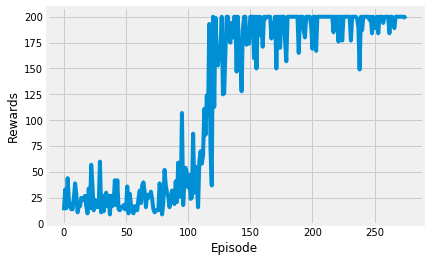

In [64]:
plot_rewards(rewards)


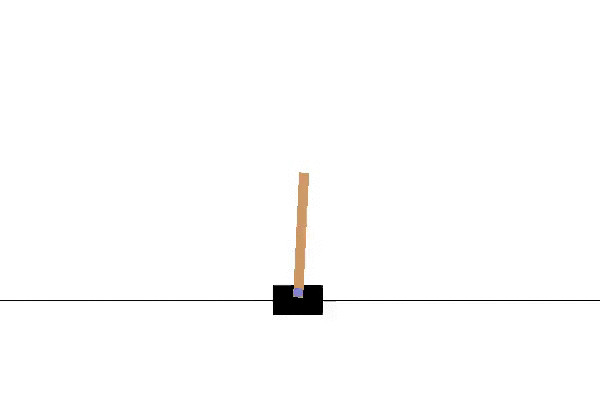
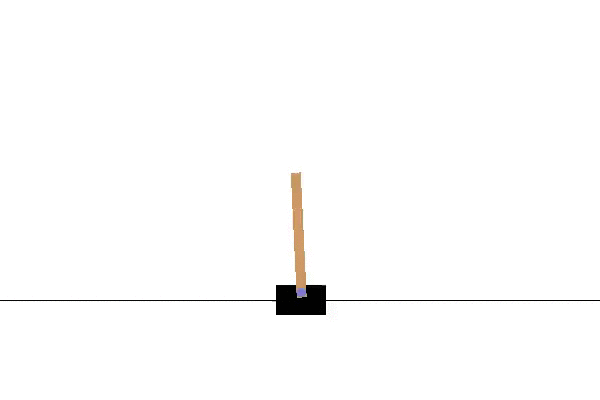
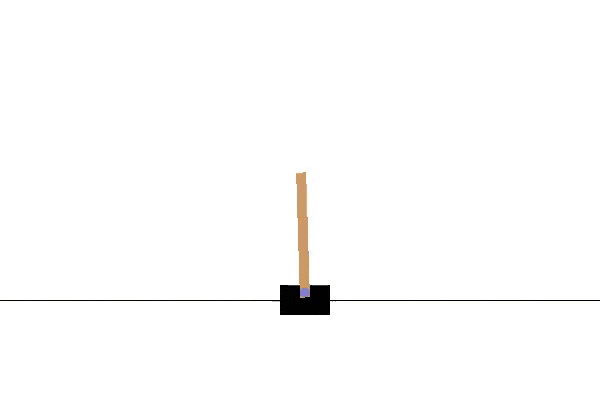
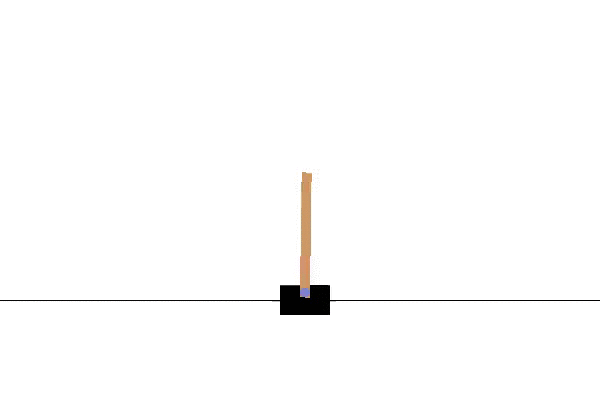
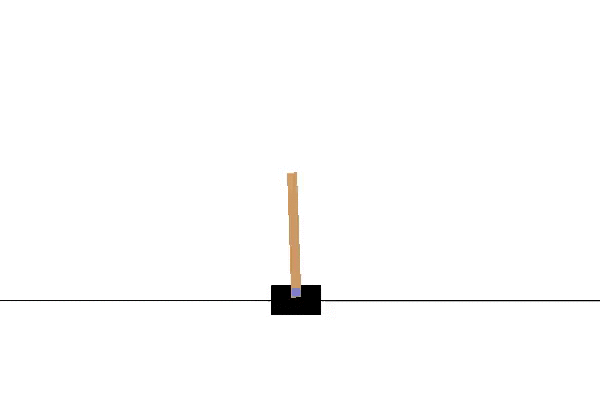

In [21]:
HTML(data=get_gif_html(env_videos=env.videos, title='Training evolution', max_n_videos=5))

In [22]:
env = make_monitored_env('CartPole-v0', 'evaluation', 1234)
evaluation_strategy = GreedyStrategy()
rewards = agent.evaluate(env, evaluation_strategy, episodes=10, render=False)

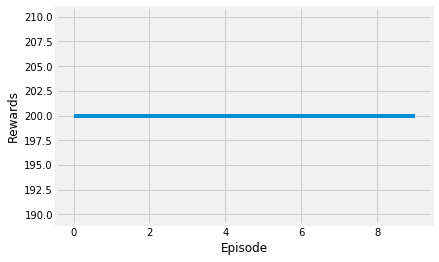

In [23]:
plot_rewards(rewards)


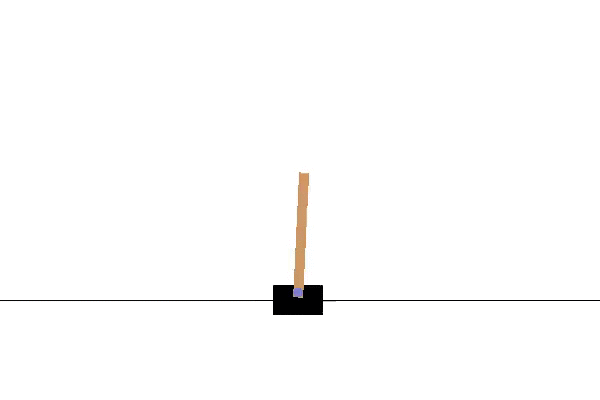
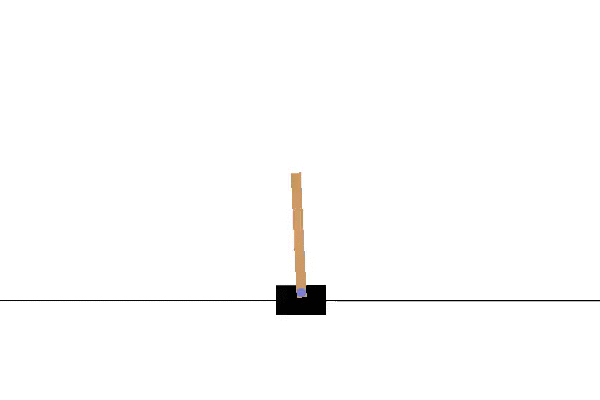
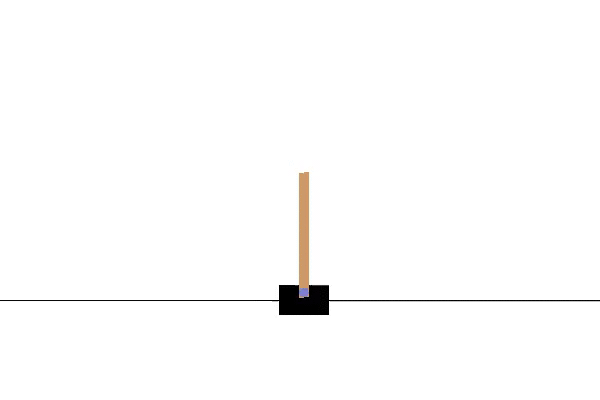

In [24]:
HTML(data=get_gif_html(env_videos=env.videos, title='Evaluation results', max_n_videos=3))